<a href="https://colab.research.google.com/github/Joearrowsmith/Algothon_2019_Workshops/blob/master/Introduction_to_Financial_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://2019.algothon.org/img/icon.png" width="200">

## [Algothon.org](http://algothon.org/)

# Algothon 2019 - Introduction to Financial Machine Learning

## Topics that will be covered in this workshop:

### Intro to Quant Finance:

- What is a financial time series?
- What is a momentum strategy?
- Key Metrics & Managing RIsk

### Intro to ML:

- How do we optimise?
- What types of models are there?
- How do we split our data?


---



A great paper on the subject which I high recommend diving into: https://arxiv.org/abs/1904.04912

In [1]:
!pip install quandl

     |████████████████████████████████| 61kB 21.8MB/s 
     |████████████████████████████████| 61kB 23.4MB/s 
     |████████████████████████████████| 2.3MB 8.0MB/s 
  Created wheel for inflection: filename=inflection-0.3.1-cp36-none-any.whl size=6076 sha256=f199cc79616a8c7a3b9b747d1bdcb3ae1d5d06e3ece6e66ed6d2eec4d6de14a9
  Stored in directory: /root/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
Successfully built inflection
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: more-itertools 7.2.0
    Uninstalling more-itertools-7.2.0:
      Successfully uninstalled more-itertools-7.2.0


In [0]:
import quandl
quandl.ApiConfig.api_key = "51zhMtVAyF2VgGsWqxzD" # keep this private

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

figsize = (15,8)

# What is a financial time series?



## Close Price for BLK

![BlackRock](http://2019.algothon.org/img/blackrock-logo-sitemap.svg)

In [4]:
start = '2015-10-15'
end = '2018-10-15'

oos_start = end
oos_end = '2019-10-15'

data = quandl.get('EOD/BLK', start_date=start, end_date=end)
close = data['Close']
close.head()

Date
2015-10-15    325.63
2015-10-16    330.83
2015-10-19    327.88
2015-10-20    327.15
2015-10-21    321.98
Name: Close, dtype: float64

In [5]:
close.tail()

Date
2018-10-09    459.71
2018-10-10    426.76
2018-10-11    417.68
2018-10-12    427.70
2018-10-15    426.94
Name: Close, dtype: float64

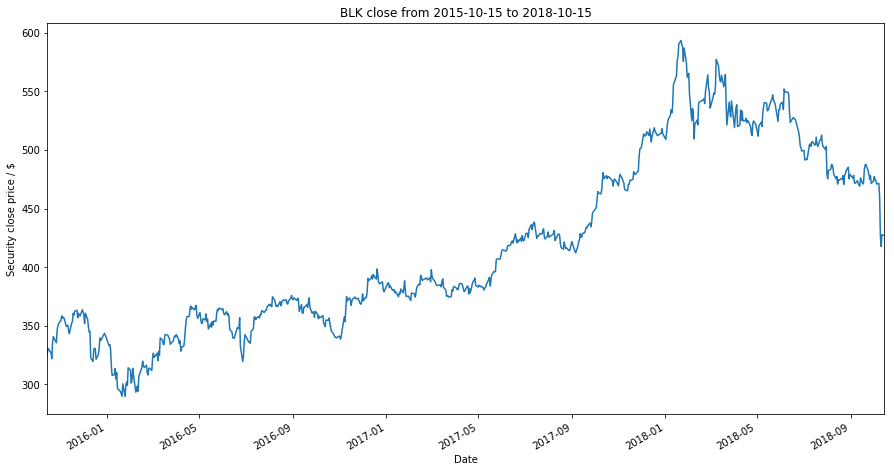

In [6]:
plt.figure(figsize=figsize)
plt.title(f'BLK close from {start} to {end}')
plt.ylabel('Security close price / $')
close.plot(label='Raw')

## Log Returns

In [7]:
log_rets = np.log(close) - np.log(close.shift(1))
log_rets.head()

Date
2015-10-15         NaN
2015-10-16    0.015843
2015-10-19   -0.008957
2015-10-20   -0.002229
2015-10-21   -0.015929
Name: Close, dtype: float64

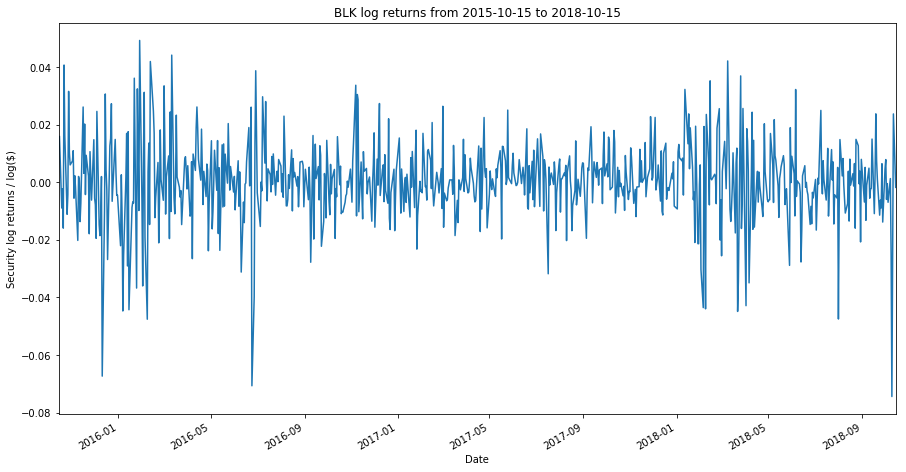

In [8]:
plt.figure(figsize=figsize)
plt.title(f'BLK log returns from {start} to {end}')
plt.ylabel('Security log returns / log($)')
log_rets.plot(label='log rets')

## Volatility

In [11]:
volatility = log_rets.shift(-1).ewm(span=252).std()
volatility.head()

Date
2015-10-15         NaN
2015-10-16    0.017536
2015-10-19    0.012796
2015-10-20    0.013613
2015-10-21    0.022869
Name: Close, dtype: float64

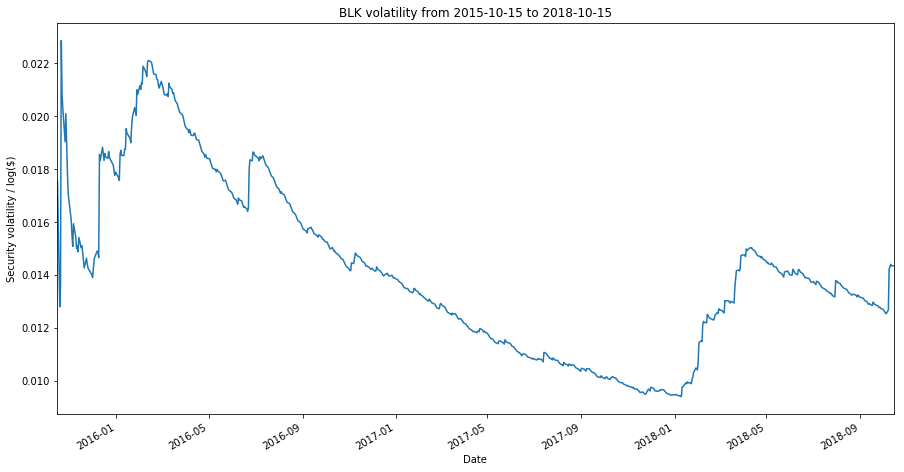

In [12]:
plt.figure(figsize=figsize)
plt.title(f'BLK volatility from {start} to {end}')
plt.ylabel('Security volatility / log($)')
volatility.plot(label='vol')

## Volatility Scaled Returns


https://youtu.be/ZJXsoZprTn8

In [13]:
rets = log_rets / volatility
rets.head()

Date
2015-10-15         NaN
2015-10-16    0.903442
2015-10-19   -0.700002
2015-10-20   -0.163737
2015-10-21   -0.696544
Name: Close, dtype: float64

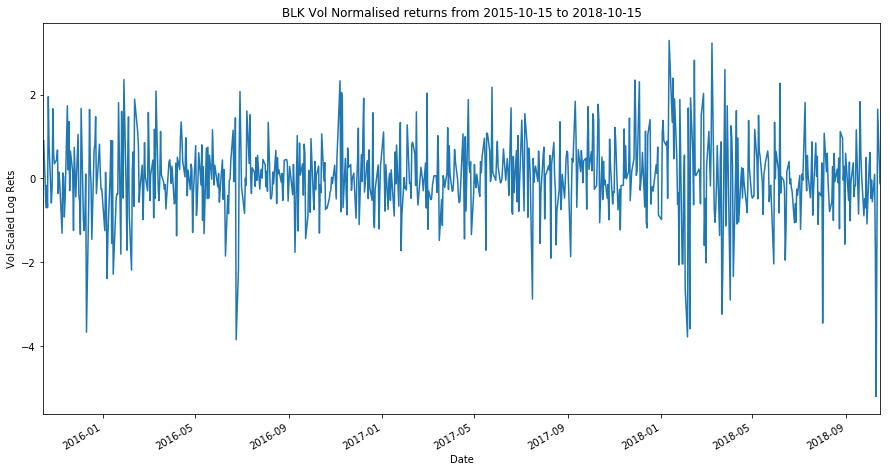

In [14]:
plt.figure(figsize=figsize)
plt.title(f'BLK Vol Normalised returns from {start} to {end}')
plt.ylabel('Vol Scaled Log Rets')
rets.plot(label='vol scaled rets')

# What is a momentum Strategy?

## Signal


In [0]:
slow_period = 300
fast_period = 150

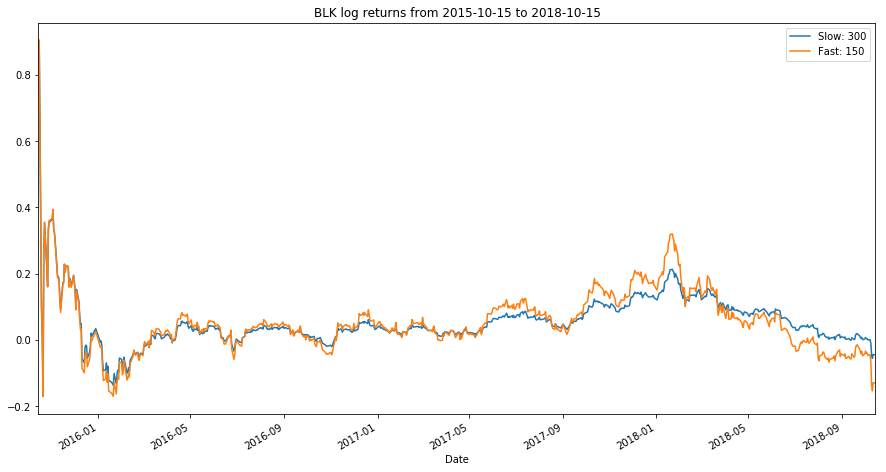

In [16]:
slow_rets = rets.ewm(span=slow_period).mean()
fast_rets = rets.ewm(span=fast_period).mean()

plt.figure(figsize=figsize)
plt.title(f'BLK log returns from {start} to {end}')
slow_rets.plot(label=f'Slow: {slow_period}')
fast_rets.plot(label=f'Fast: {fast_period}')

plt.legend()

In [17]:
diff = fast_rets - slow_rets
diff.head()

Date
2015-10-15         NaN
2015-10-16    0.000000
2015-10-19   -0.002672
2015-10-20   -0.002356
2015-10-21   -0.003535
Name: Close, dtype: float64

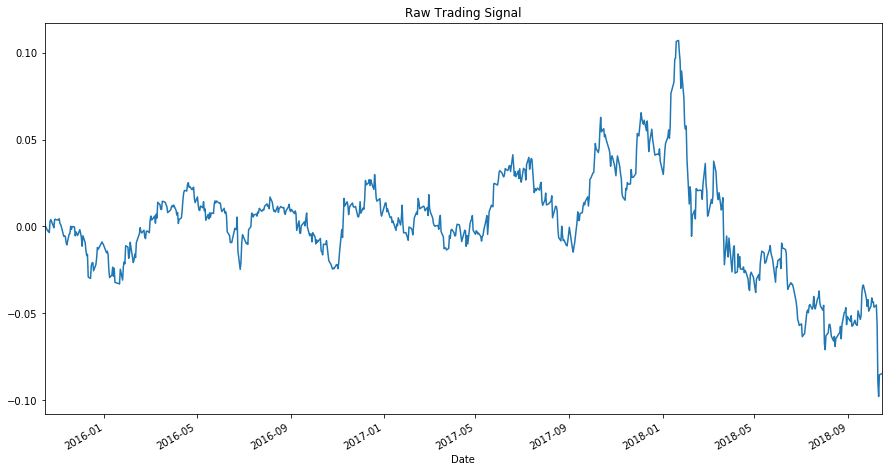

In [18]:
plt.figure(figsize=figsize)
plt.title('Raw Trading Signal')
diff.plot(label='raw signal')

In [0]:
raw_macd = diff

In [0]:
exp_diff = np.sqrt(np.square(diff).ewm(span=60).mean())
rms_macd = diff / exp_diff

In [0]:
std_diff = diff.ewm(span=63).std()
std_macd = diff / std_diff

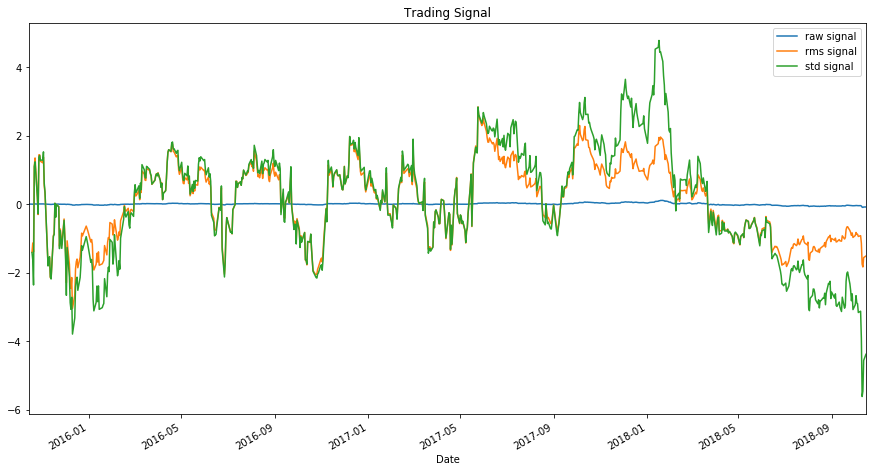

In [22]:
plt.figure(figsize=figsize)
plt.title('Trading Signal')
raw_macd.plot(label='raw signal')
rms_macd.plot(label='rms signal')
std_macd.plot(label='std signal')
plt.legend()

## Position Functions

A position function is a function between -1 and 1 which indicates how to place the trade. Value of 1 is long, value of -1 is short. This can either be an absolute value (-1, 0, 1) or it can be continuous relating to how long or how short your position should be.

In [0]:
def moskowitz_pos_func(x):
  # Moskowitz et al. 2012
  return x * np.exp( - (x**2)/4) /0.89

def tanh_pos_func(x):
  return np.tanh(x)

def abs_pos_func(x):
  return np.sign(x)

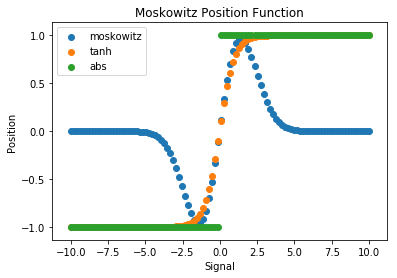

In [25]:
x = np.linspace(-10, 10, 100)
y_moskowitz = moskowitz_pos_func(x)
y_tanh = tanh_pos_func(x)
y_abs = abs_pos_func(x)

plt.title("Moskowitz Position Function")
plt.ylabel("Position")
plt.xlabel("Signal")
plt.scatter(x,y_moskowitz, label='moskowitz')
plt.scatter(x,y_tanh, label='tanh')
plt.scatter(x,y_abs, label='abs')
plt.legend()

In [0]:
moskowitz_raw_pos = moskowitz_pos_func(raw_macd)
moskowitz_rms_pos = moskowitz_pos_func(rms_macd)
moskowitz_std_pos = moskowitz_pos_func(std_macd)

tanh_raw_pos = tanh_pos_func(raw_macd)
tanh_rms_pos = tanh_pos_func(rms_macd)
tanh_std_pos = tanh_pos_func(std_macd)

abs_raw_pos = abs_pos_func(raw_macd)
abs_rms_pos = abs_pos_func(rms_macd)
abs_std_pos = abs_pos_func(std_macd)

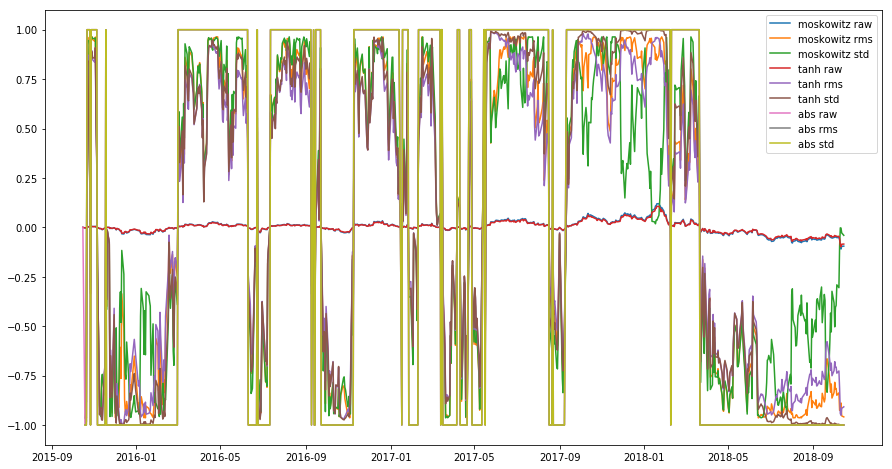

In [28]:
plt.figure(figsize=figsize)
plt.plot(moskowitz_raw_pos, label='moskowitz raw')
plt.plot(moskowitz_rms_pos, label='moskowitz rms')
plt.plot(moskowitz_std_pos, label='moskowitz std')
plt.plot(tanh_raw_pos, label='tanh raw')
plt.plot(tanh_rms_pos, label='tanh rms')
plt.plot(tanh_std_pos, label='tanh std')
plt.plot(abs_raw_pos, label='abs raw')
plt.plot(abs_rms_pos, label='abs rms')
plt.plot(abs_std_pos, label='abs std')

plt.legend()

## Performance

In [0]:
target_rets = rets.shift(-1)

moskowitz_raw_perf = target_rets * moskowitz_raw_pos
moskowitz_rms_perf = target_rets * moskowitz_rms_pos
moskowitz_std_perf = target_rets * moskowitz_std_pos
tanh_raw_perf = target_rets * tanh_raw_pos
tanh_rms_perf = target_rets * tanh_rms_pos
tanh_std_perf = target_rets * tanh_std_pos
abs_raw_perf = target_rets * abs_raw_pos
abs_rms_perf = target_rets * abs_rms_pos
abs_std_perf = target_rets * abs_std_pos

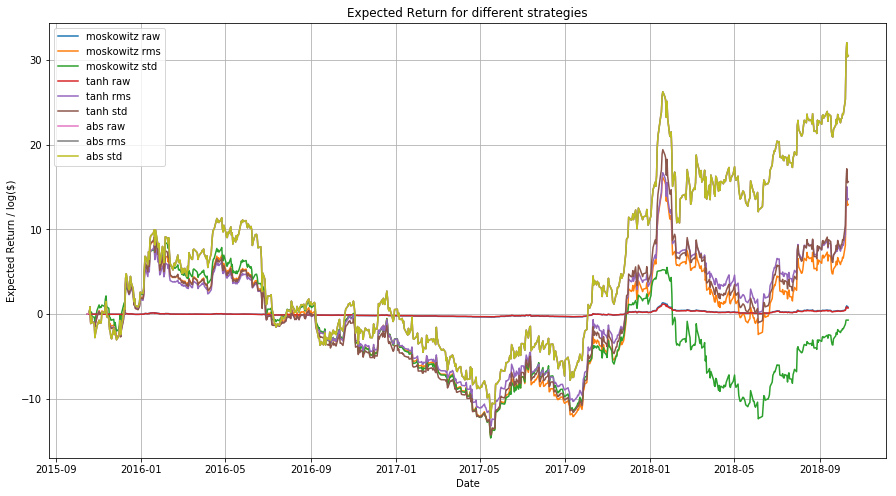

In [30]:
plt.figure(figsize=figsize)
plt.plot(np.cumsum(moskowitz_raw_perf), label='moskowitz raw')
plt.plot(np.cumsum(moskowitz_rms_perf), label='moskowitz rms')
plt.plot(np.cumsum(moskowitz_std_perf), label='moskowitz std')
plt.plot(np.cumsum(tanh_raw_perf), label='tanh raw')
plt.plot(np.cumsum(tanh_rms_perf), label='tanh rms')
plt.plot(np.cumsum(tanh_std_perf), label='tanh std')
plt.plot(np.cumsum(abs_raw_perf), label='abs raw')
plt.plot(np.cumsum(abs_rms_perf), label='abs rms')
plt.plot(np.cumsum(abs_std_perf), label='abs std')


plt.title("Expected Return for different strategies")
plt.ylabel("Expected Return / log($)")
plt.xlabel("Date")
plt.grid(True)
plt.legend()

## Time Leakage

What happens if during our backtest we leak future data into the past?

If your results look too good to be true; this is the first thing to check. Time leakage can occur in subtle ways so take care whilst building and backtesting your models.

In [0]:
target_rets = rets.shift(1)

moskowitz_raw_perf = target_rets * moskowitz_raw_pos
moskowitz_rms_perf = target_rets * moskowitz_rms_pos
moskowitz_std_perf = target_rets * moskowitz_std_pos
tanh_raw_perf = target_rets * tanh_raw_pos
tanh_rms_perf = target_rets * tanh_rms_pos
tanh_std_perf = target_rets * tanh_std_pos

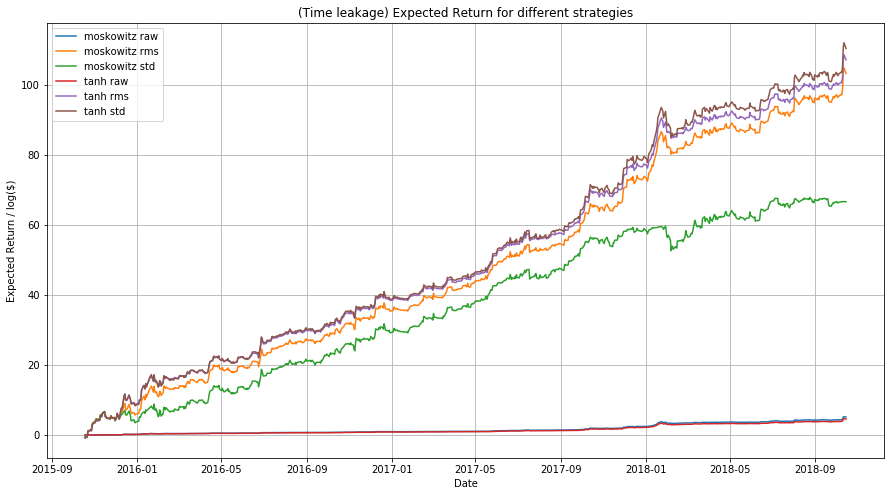

In [32]:
plt.figure(figsize=figsize)
plt.plot(np.cumsum(moskowitz_raw_perf), label='moskowitz raw')
plt.plot(np.cumsum(moskowitz_rms_perf), label='moskowitz rms')
plt.plot(np.cumsum(moskowitz_std_perf), label='moskowitz std')
plt.plot(np.cumsum(tanh_raw_perf), label='tanh raw')
plt.plot(np.cumsum(tanh_rms_perf), label='tanh rms')
plt.plot(np.cumsum(tanh_std_perf), label='tanh std')

plt.title("(Time leakage) Expected Return for different strategies")
plt.ylabel("Expected Return / log($)")
plt.xlabel("Date")
plt.grid(True)
plt.legend()



---

# An ensemble of signals

In [0]:
fasts = [30, 90, 150]
slows = [90, 150, 300]
warm_up_period = 252
signals = None

In [0]:
def get_trade_signal(log_rets, slow, fast):
  ## get slow and fast means
  slow_rets = rets.ewm(span=slow).mean()
  fast_rets = rets.ewm(span=fast).mean()
  
  ## calculate signal
  diff = fast_rets - slow_rets 
  
  ## normalise signal by rms
  rms = np.sqrt(np.square(diff).ewm(span=60).mean())
  normed_diff = diff / rms
  return normed_diff

def moskowitz_pos_func(x):
  # Moskowitz et al. 2012
  return x * np.exp( - (x**2)/4) /0.89

In [35]:
for slow, fast in zip(slows, fasts):
  signal = get_trade_signal(rets, slow, fast)
  if signals is None:
    signals = pd.DataFrame(data = {f'{slow},{fast}' : signal})
  else:
    signals[f'{slow},{fast}'] = signal
    
macd_signal = signals.mean(axis=1)
macd_signal.head()

Date
2015-10-15         NaN
2015-10-16         NaN
2015-10-19   -1.402574
2015-10-20   -1.130948
2015-10-21   -1.390182
dtype: float64

No handles with labels found to put in legend.


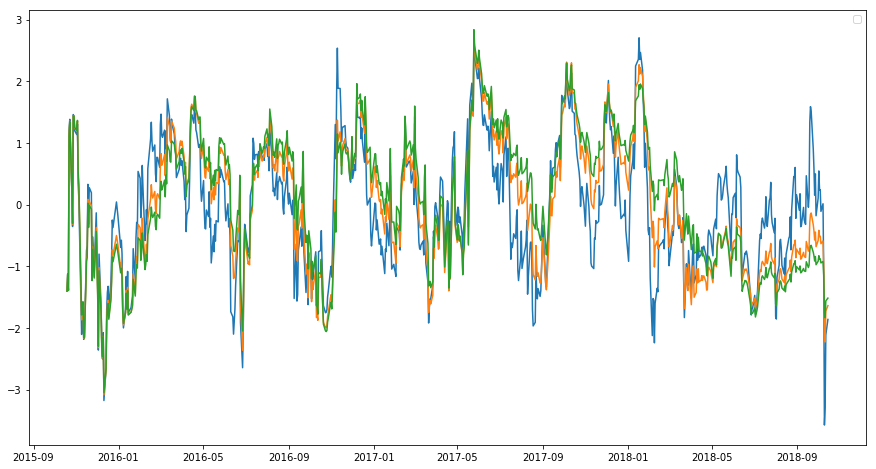

In [36]:
plt.figure(figsize=figsize)
plt.plot(signals)
plt.legend()

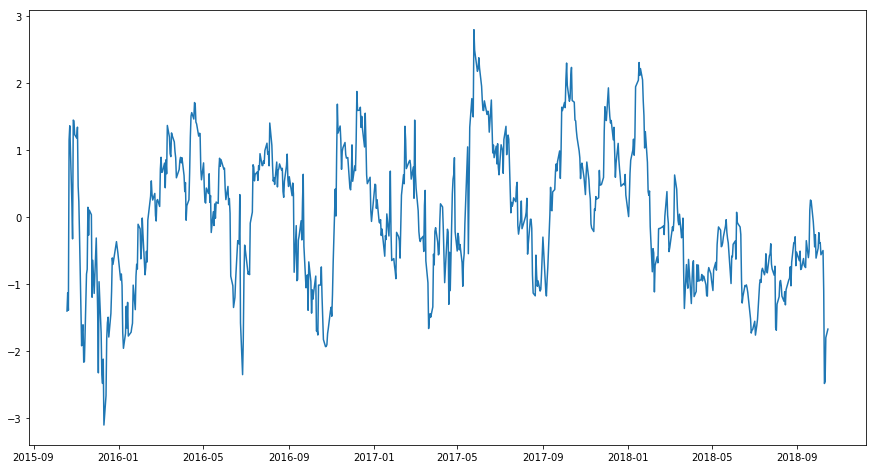

In [37]:
plt.figure(figsize=figsize)
plt.plot(macd_signal)

In [38]:
macd_pos = moskowitz_pos_func(macd_signal)
macd_pos.head()

Date
2015-10-15         NaN
2015-10-16         NaN
2015-10-19   -0.963714
2015-10-20   -0.922959
2015-10-21   -0.963500
dtype: float64

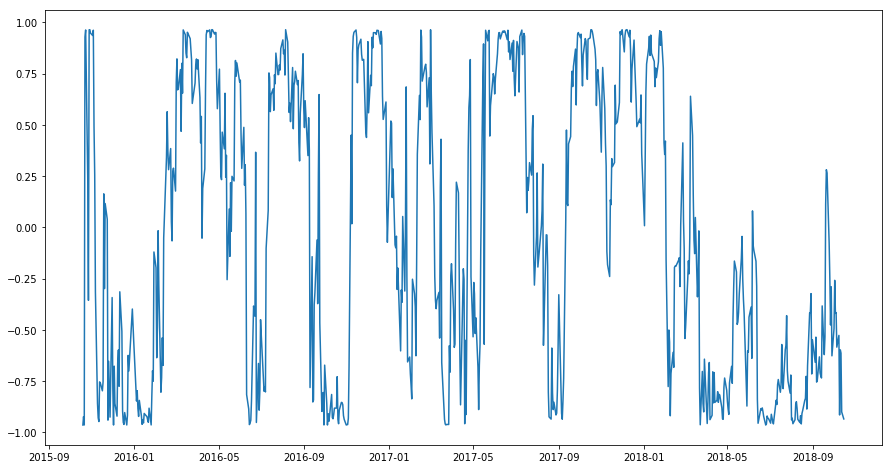

In [39]:
plt.figure(figsize=figsize)
plt.plot(macd_pos)

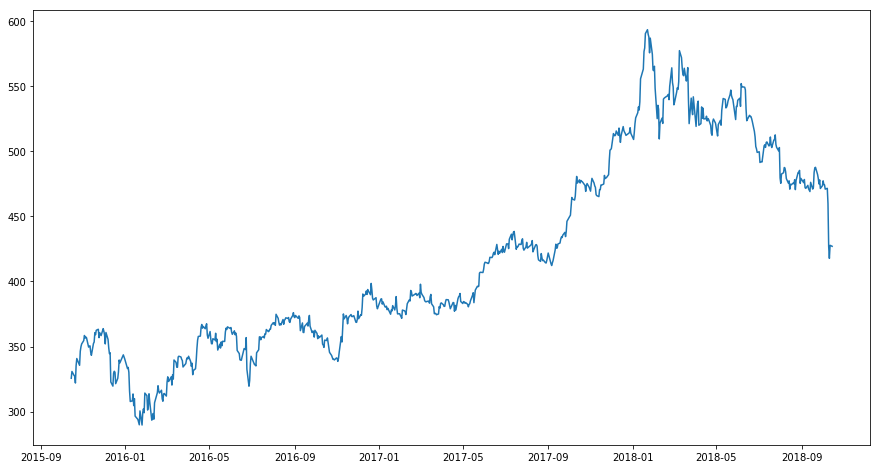

In [40]:
plt.figure(figsize=figsize)
plt.plot(close)

In [41]:
target_rets = rets.shift(-1)
expected_return = target_rets * macd_pos
expected_return.head()

Date
2015-10-15         NaN
2015-10-16         NaN
2015-10-19    0.157795
2015-10-20    0.642882
2015-10-21   -1.881370
dtype: float64

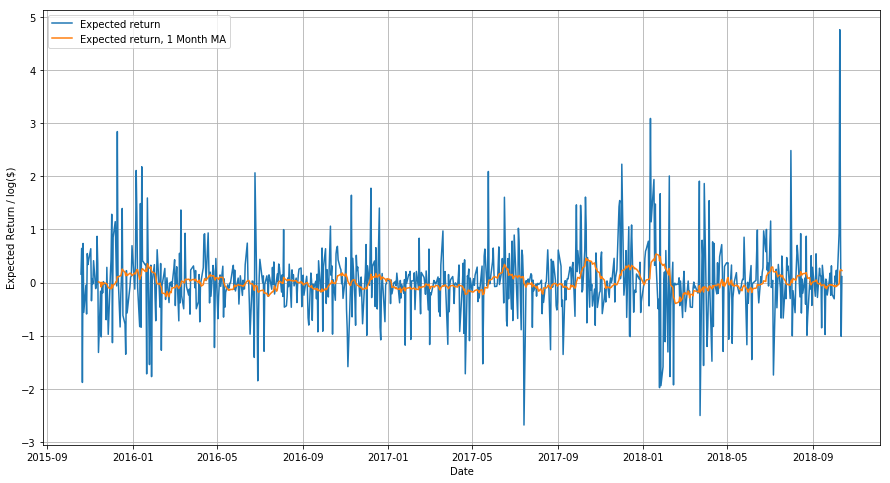

In [42]:
plt.figure(figsize=figsize)
plt.plot(expected_return, label="Expected return")
plt.plot(expected_return.rolling(20).mean(), label="Expected return, 1 Month MA")
plt.xlabel("Date")
plt.ylabel("Expected Return / log($)")
plt.legend()
plt.grid(True)

Text(0, 0.5, 'Cum Expected Return / log($)')

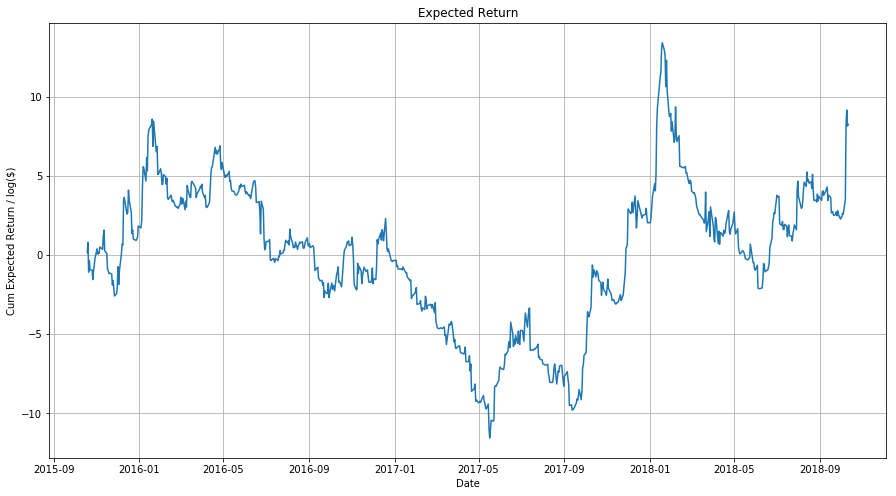

In [43]:
plt.figure(figsize=figsize)
plt.title('Expected Return')
plt.plot(np.cumsum(expected_return))
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Cum Expected Return / log($)")

## Annualised Rolling Sharpe

In [0]:
rfr = 0.02 #risk free rate

In [45]:
annualised_sharpe = np.sqrt(252) * (expected_return.rolling(252).mean() - rfr) / expected_return.rolling(252).std()
annualised_sharpe.head()

Date
2015-10-15   NaN
2015-10-16   NaN
2015-10-19   NaN
2015-10-20   NaN
2015-10-21   NaN
dtype: float64

In [46]:
annualised_sharpe.tail()

Date
2018-10-09    0.518301
2018-10-10    0.464049
2018-10-11    0.297840
2018-10-12    0.367985
2018-10-15         NaN
dtype: float64

Text(0, 0.5, 'Annualised Sharpe')

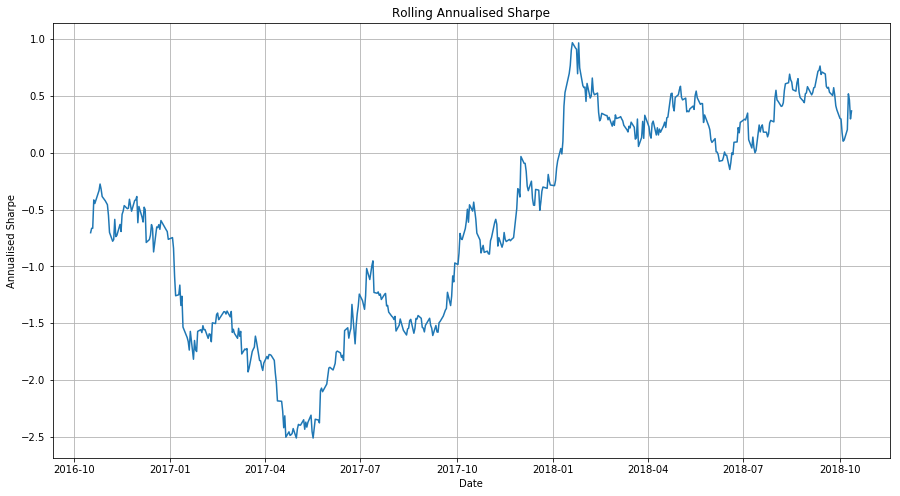

In [47]:
plt.figure(figsize=figsize)
plt.title("Rolling Annualised Sharpe")
plt.plot(annualised_sharpe)
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Annualised Sharpe")

## Transaction Cost Analysis

In [48]:
turnover = np.abs(macd_pos.diff())
turnover.head()

Date
2015-10-15         NaN
2015-10-16         NaN
2015-10-19         NaN
2015-10-20    0.040755
2015-10-21    0.040541
dtype: float64

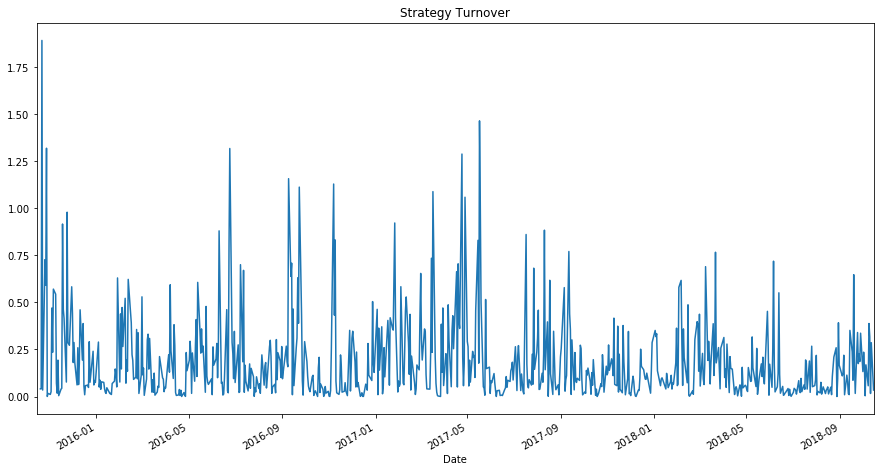

In [49]:
plt.figure(figsize=figsize)
plt.title("Strategy Turnover")
turnover.plot()

In [0]:
def get_perf(expected_rets, turnover, c):
  perf = expected_return - turnover * c
  return perf

In [0]:
costs = [1, 0.5, 1e-1, 1e-2, 1e-3]

Text(0, 0.5, 'Expected return / log($)')

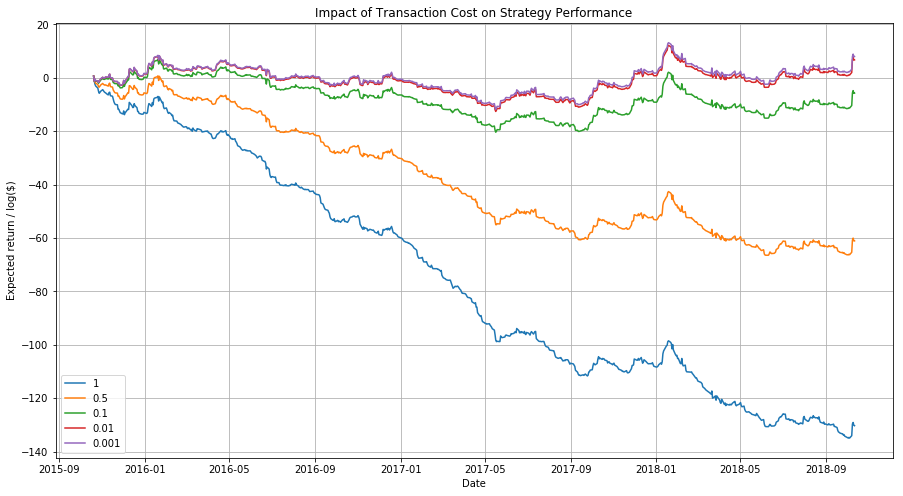

In [52]:
plt.figure(figsize=figsize)
for c in costs:
  perf = get_perf(expected_return, turnover, c)
  plt.plot(perf.cumsum(), label=c)

plt.title("Impact of Transaction Cost on Strategy Performance")
plt.legend()
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Expected return / log($)")

Text(0, 0.5, 'Sharpe')

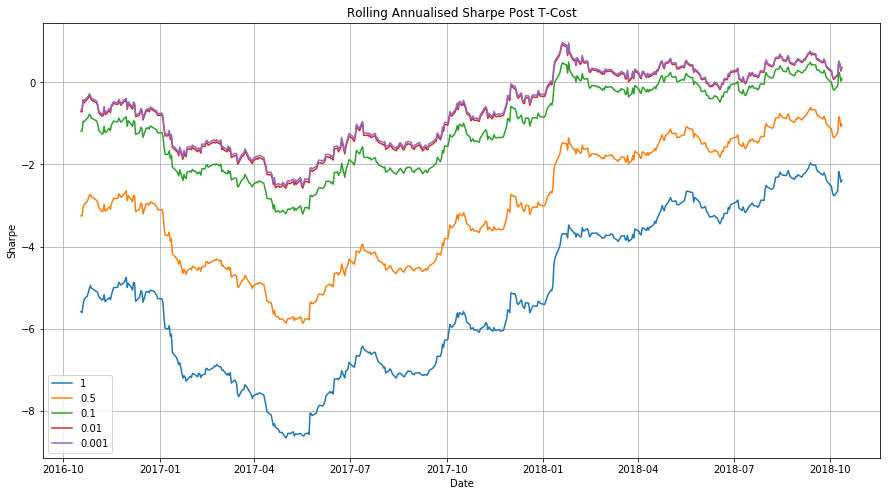

In [53]:
plt.figure(figsize=figsize)
for c in costs:
  perf = get_perf(expected_return, turnover, c)
  annualised_sharpe = np.sqrt(252) * (perf.rolling(252).mean() - rfr) / perf.rolling(252).std()
  plt.plot(annualised_sharpe, label=c)

plt.title("Rolling Annualised Sharpe Post T-Cost")
plt.legend()
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Sharpe")

## Diversification across securities:

*Left to the reader:* **Extend the strategy above to include the 6 tickers below (or any others you want to include).**

- How does this impact performance?
- Why do we do this?

In [0]:
tickers = ['EOD/BLK', 'EOD/ZNH', 'EOD/VTV', 'EOD/TCPC', 'EOD/SMPL', 'EOD/SMLF']

In [0]:
## your code goes here ##

# So why use Machine Learning?

The aim of machine learning is to partially automate the research process using historical data to find the future's optimal signal and positition.

### How can we do this?
- Create a strategy to learn the next step ahead and directly learn the position function.

### A naive approach:
- Model inputs: recent historical data
- Predict the next step ahead, the next timestep is the target value for the current timestep.
- Use mean squared error to calcuate the error from the prediction to the target value.
- Directly learn the position function so use tanh as the activation for the output layer.

In [56]:
close.head()

Date
2015-10-15    325.63
2015-10-16    330.83
2015-10-19    327.88
2015-10-20    327.15
2015-10-21    321.98
Name: Close, dtype: float64

In [0]:
def get_log_rets(close, shift=1):
  assert shift >= 1, f'the shift must be >= than one day, as otherwise the log returns is using data from the future'
  log_rets = np.log(close) - np.log(close.shift(shift))
  return log_rets
  
def get_vol_scale_rets(log_rets, shift=1, vol_span=252):
  assert shift >= 1, f'the shift must be >= than one day, as otherwise the log returns is using data from the future'
  assert vol_span > 7, 'to get a reasonable estimate of volatility you should be using at least 7 data points'
  volatility = log_rets.shift(shift).ewm(span=vol_span).std() ## volatility is calcualted by using a rolling estimate of the recent standard deviation.
  return log_rets / volatility
  
def drop_rows(array, drop=60):
  array = array[drop:]
  return array

In [0]:
def get_windows(time_series, window_size, num_inputs=1, recurrence=False):
  time_series_len = len(time_series)
  windows = []
  for row_idx in range(window_size, time_series_len):
    start = row_idx - window_size
    end = row_idx
    window = time_series[start:end]
    windows.append(window)
  windows = np.stack(windows)
  if recurrence:
    windows = np.reshape(windows, (len(windows), window_size, num_inputs))
  else:
    windows = np.reshape(windows, (len(windows), 1, num_inputs * window_size))
  return windows
  
def get_targets(target_rets, window_size):
  assert window_size >= 1, f'window size must be >= to 1.'
  targets = rets.shift(window_size * -1)  
  targets = targets.to_numpy()
  targets = targets[:-window_size]
  len_targets = len(targets)
  targets = np.reshape(targets, (len_targets, 1))
  return targets

In [0]:
def test_train_split(x, y, split=0.7):
  length = len(x)
  assert length == len(y), f'length is not an equal value to test: {length} != {len(y)}'
  split_idx = int(length*split)
  x_train, x_test = x[:split_idx], x[split_idx:]
  y_train, y_test = y[:split_idx], y[split_idx:]
  return x_train, y_train, x_test, y_test

In [0]:
log_rets = get_log_rets(close)
rets  = get_vol_scale_rets(log_rets)
rets = drop_rows(rets, 3)

In [61]:
window_size = 15
recurrence = False

windows = get_windows(rets, window_size, recurrence=recurrence)
targets = get_targets(rets, window_size)

x_train, y_train, x_test, y_test = test_train_split(windows, targets)

print(x_train.shape)
print(y_train.shape)

(516, 1, 15)
(516, 1)


# The "Machine Learning"

In [0]:
import tensorflow as tf

In [0]:
def get_linear_model(outputs=1, direct_output=False):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(1, activation='tanh'))
  act = None if direct_output else 'tanh'
  model.add(tf.keras.layers.Dense(outputs, activation=act))  # if no activiation function is used, then a position function should be used
  return model

def get_mlp_model(outputs=1, layers=[10], direct_output=False):
  model = tf.keras.Sequential()
  for units in layers:
    model.add(tf.keras.layers.Dense(units, activation='tanh'))
  act = None if direct_output else 'tanh'
  model.add(tf.keras.layers.Dense(outputs, activation=act))  # if no activiation function is used, then a position function should be used
  return model

def get_lstm_model(outputs=1, units=5, direct_output=False):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(units))
  act = None if direct_output else 'tanh'
  model.add(tf.keras.layers.Dense(outputs, activation=act))  # if no activiation function is used, then a position function should be used
  return model

In [0]:
def sharpe(y_true, y_pred): # position, target returns
  ret = y_pred * y_true
  expected_ret = tf.reduce_mean(ret)
  return - expected_ret / tf.math.reduce_std(ret) 

In [0]:
def train_model(x_train, y_train, x_test, y_test, 
                model, loss_func, epochs, 
                opti=tf.keras.optimizers.Adam()):
  model.compile(loss=loss_func, optimizer=opti)
  hist = model.fit(x=x_train, y=y_train, batch_size=128, epochs=epochs, verbose=1, validation_data=(x_test, y_test))

  fig, ax = plt.subplots(2, 1, figsize=figsize)
  ax[0].set_title('loss')
  ax[0].plot(hist.history['loss'])
  ax[1].set_title('val loss')
  ax[1].plot(hist.history['val_loss'])
  return model

## Train our models

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 516 samples, validate on 222 samples
Epoch 1/150
516/516 [==============================] - 1s 1ms/sample - loss: 1.1460 - val_loss: 1.9739
Epoch 2/150
516/516 [==============================] - 0s 32us/sample - loss: 1.1400 - val_loss: 1.9702
Epoch 3/150
516/516 [==============================] - 0s 40us/sample - loss: 1.1356 - val_loss: 1.9726
Epoch 4/150
516/516 [==============================] - 0s 27us/sample - loss: 1.1262 - val_loss: 1.9746
Epoch 5/150
516/516 [==============================] - 0s 30us/sample - loss: 1.1238 - val_loss: 1.9670
Epoch 6/150
516/516 [==============================] - 0s 27us/sample - loss: 1.1220 - val_loss: 1.9646
Epoch 7/150
516/516 [==============================] - 0s 26us/sample - loss: 1.1014 - val_loss: 1.9574
Epoch 8/150
516/516 [==============================] - 0s 30us/sample - loss: 1.1087 - val_loss: 1.9405
Epoch 9/150
516/516 [=====================

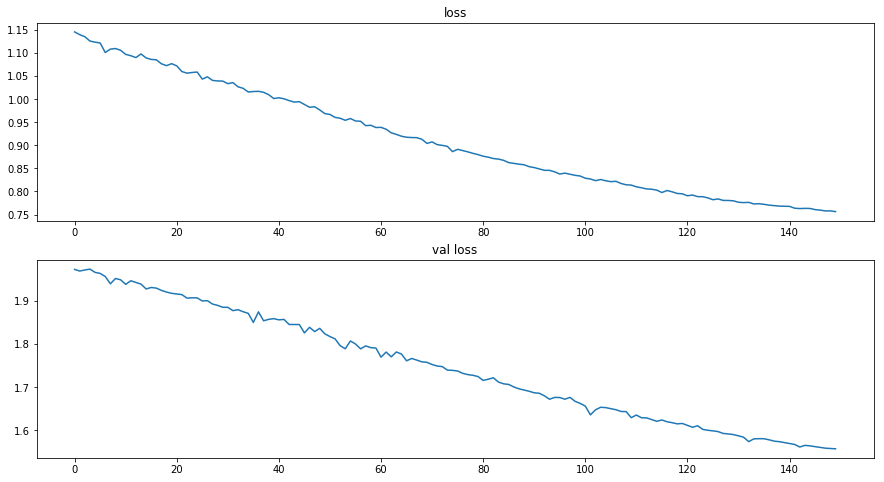

In [67]:
linear_mse_model = get_linear_model()
linear_mse_model = train_model(x_train, y_train, x_test, y_test,
                               linear_mse_model, 'mse', 150)

Train on 516 samples, validate on 222 samples
Epoch 1/300
516/516 [==============================] - 0s 346us/sample - loss: 0.0076 - val_loss: -1.6075e-05
Epoch 2/300
516/516 [==============================] - 0s 27us/sample - loss: 0.0036 - val_loss: 0.0025
Epoch 3/300
516/516 [==============================] - 0s 31us/sample - loss: 0.0063 - val_loss: -0.0031
Epoch 4/300
516/516 [==============================] - 0s 27us/sample - loss: 0.0032 - val_loss: 0.0019
Epoch 5/300
516/516 [==============================] - 0s 28us/sample - loss: 0.0033 - val_loss: 0.0268
Epoch 6/300
516/516 [==============================] - 0s 30us/sample - loss: 0.0029 - val_loss: 0.0024
Epoch 7/300
516/516 [==============================] - 0s 26us/sample - loss: 0.0010 - val_loss: 2.9343e-04
Epoch 8/300
516/516 [==============================] - 0s 27us/sample - loss: 0.0079 - val_loss: 0.0019
Epoch 9/300
516/516 [==============================] - 0s 33us/sample - loss: 0.0041 - val_loss: -4.8255e-04
Ep

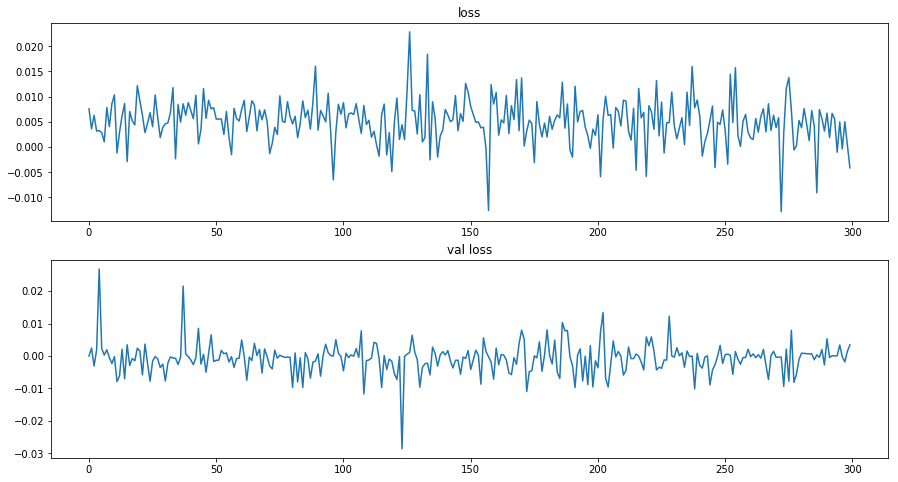

In [68]:
linear_sharpe_model = get_linear_model()
linear_sharpe_model = train_model(x_train, y_train, x_test, y_test, 
                                  linear_sharpe_model, sharpe, 300,
                                  tf.keras.optimizers.Adam(0.00005))

Train on 516 samples, validate on 222 samples
Epoch 1/100
516/516 [==============================] - 0s 446us/sample - loss: 1.1604 - val_loss: 1.8589
Epoch 2/100
516/516 [==============================] - 0s 28us/sample - loss: 1.0643 - val_loss: 1.7970
Epoch 3/100
516/516 [==============================] - 0s 29us/sample - loss: 0.9688 - val_loss: 1.7182
Epoch 4/100
516/516 [==============================] - 0s 29us/sample - loss: 0.8885 - val_loss: 1.6527
Epoch 5/100
516/516 [==============================] - 0s 41us/sample - loss: 0.8353 - val_loss: 1.6068
Epoch 6/100
516/516 [==============================] - 0s 30us/sample - loss: 0.8005 - val_loss: 1.5766
Epoch 7/100
516/516 [==============================] - 0s 34us/sample - loss: 0.7881 - val_loss: 1.5645
Epoch 8/100
516/516 [==============================] - 0s 30us/sample - loss: 0.7756 - val_loss: 1.5576
Epoch 9/100
516/516 [==============================] - 0s 29us/sample - loss: 0.7689 - val_loss: 1.5457
Epoch 10/100
516/

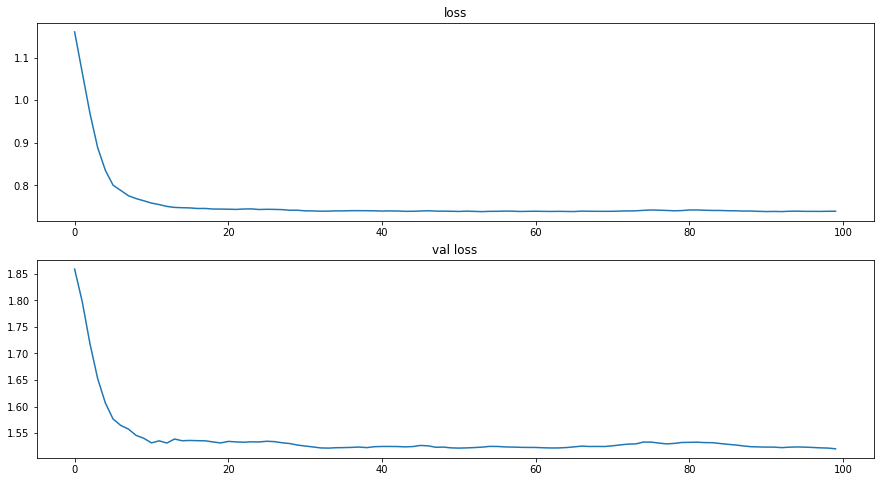

In [69]:
mlp_mse_model = get_mlp_model(layers=[5, 10])
mlp_mse_model = train_model(x_train, y_train, x_test, y_test,
                            mlp_mse_model, 'mse', 100)

Train on 516 samples, validate on 222 samples
Epoch 1/300
516/516 [==============================] - 0s 509us/sample - loss: 0.0015 - val_loss: -0.0021
Epoch 2/300
516/516 [==============================] - 0s 33us/sample - loss: 0.0074 - val_loss: -0.0017
Epoch 3/300
516/516 [==============================] - 0s 32us/sample - loss: 0.0116 - val_loss: -0.0016
Epoch 4/300
516/516 [==============================] - 0s 33us/sample - loss: -0.0044 - val_loss: -0.0015
Epoch 5/300
516/516 [==============================] - 0s 34us/sample - loss: -0.0016 - val_loss: 0.0031
Epoch 6/300
516/516 [==============================] - 0s 33us/sample - loss: 0.0035 - val_loss: -0.0011
Epoch 7/300
516/516 [==============================] - 0s 32us/sample - loss: -5.8152e-04 - val_loss: -3.4868e-04
Epoch 8/300
516/516 [==============================] - 0s 31us/sample - loss: 0.0060 - val_loss: -0.0019
Epoch 9/300
516/516 [==============================] - 0s 29us/sample - loss: -0.0036 - val_loss: -0.00

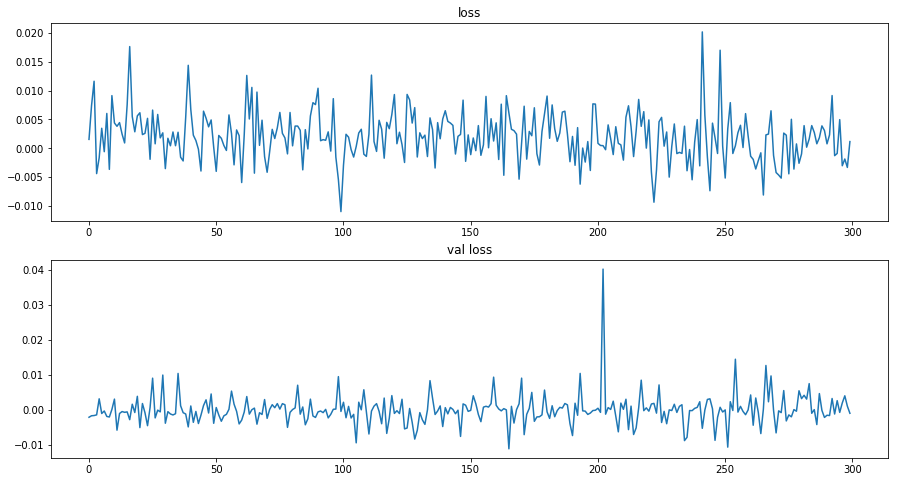

In [70]:
mlp_sharpe_model = get_mlp_model(layers=[5, 10])
mlp_sharpe_model = train_model(x_train, y_train, x_test, y_test,
                               mlp_sharpe_model, sharpe, 300,
                               tf.keras.optimizers.Adam(0.00001))

In [71]:
window_size = 60
recurrence = True

windows = get_windows(rets, window_size, recurrence=recurrence)
targets = get_targets(rets, window_size)

xr_train, yr_train, xr_test, yr_test = test_train_split(windows, targets)

print(xr_train.shape)
print(yr_train.shape)

(485, 60, 1)
(485, 1)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 485 samples, validate on 208 samples
Epoch 1/300
485/485 [==============================] - 1s 2ms/sample - loss: 0.6959 - val_loss: 1.5290
Epoch 2/300
485/485 [==============================] - 0s 381us/sample - loss: 0.6938 - val_loss: 1.5404
Epoch 3/300
485/485 [==============================] - 0s 371us/sample - loss: 0.6892 - val_loss: 1.5432
Epoch 4/300
485/485 [==============================] - 0s 399us/sample - loss: 0.6884 - val_loss: 1.5450
Epoch 5/300
485/485 [==============================] - 0s 380us/sample - loss: 0.6868 - val_loss: 1.5445
Epoch 6/300
485/485 [==============================] - 0s 376us/sample - loss: 0.6859 - val_loss: 1.5447
Epoch 7/300
485/485 [==============================] - 0s 376us/sample - loss: 0.6853 - val_loss: 1.5442
Epoch 8/300
485/485 [==============================] - 0s 417us/sample - loss: 0.6849 - val_loss: 1.5421
Epoch 9/300
485/485 [=

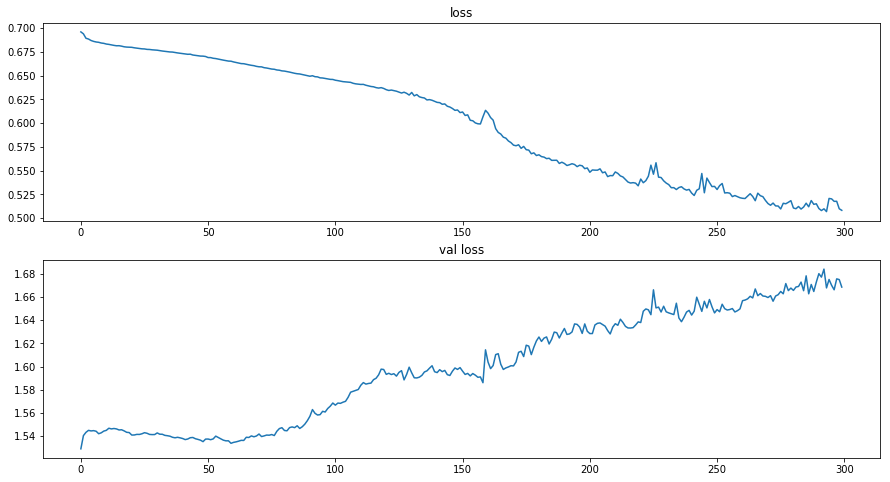

In [72]:
lstm_mse_model = get_lstm_model(units=10)
lstm_mse_model = train_model(xr_train, yr_train, xr_test, yr_test,
                             lstm_mse_model, 'mse', 300)

Train on 485 samples, validate on 208 samples
Epoch 1/300
485/485 [==============================] - 1s 2ms/sample - loss: -0.1081 - val_loss: 0.0337
Epoch 2/300
485/485 [==============================] - 0s 364us/sample - loss: -0.1538 - val_loss: 0.0358
Epoch 3/300
485/485 [==============================] - 0s 394us/sample - loss: -0.1457 - val_loss: 0.0092
Epoch 4/300
485/485 [==============================] - 0s 406us/sample - loss: -0.1533 - val_loss: 0.0294
Epoch 5/300
485/485 [==============================] - 0s 380us/sample - loss: -0.1601 - val_loss: 0.0163
Epoch 6/300
485/485 [==============================] - 0s 390us/sample - loss: -0.1583 - val_loss: 0.0190
Epoch 7/300
485/485 [==============================] - 0s 398us/sample - loss: -0.1686 - val_loss: 0.0145
Epoch 8/300
485/485 [==============================] - 0s 403us/sample - loss: -0.1781 - val_loss: 0.0083
Epoch 9/300
485/485 [==============================] - 0s 378us/sample - loss: -0.1803 - val_loss: -0.0025
E

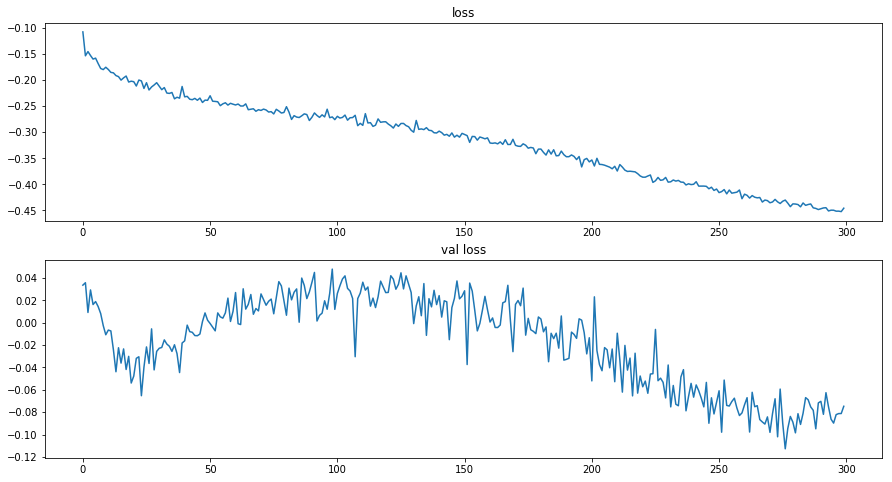

In [73]:
lstm_sharpe_model = get_lstm_model(units=10)
lstm_sharpe_model = train_model(xr_train, yr_train, xr_test, yr_test,
                                lstm_sharpe_model, sharpe, 300)

In [0]:
# Get test performance

In [0]:
lin_mse_position = linear_mse_model.predict(x_test)
lin_sharpe_position = linear_sharpe_model.predict(x_test)

mlp_mse_position = mlp_mse_model.predict(x_test)
mlp_sharpe_position = mlp_sharpe_model.predict(x_test)

lstm_mse_position = lstm_mse_model.predict(xr_test)
lstm_sharpe_position = lstm_sharpe_model.predict(xr_test)

In [0]:
lin_mse_rets = y_test * lin_mse_position
lin_sharpe_rets = y_test * lin_sharpe_position

mlp_mse_rets = y_test * mlp_mse_position
mlp_sharpe_rets = y_test * mlp_sharpe_position

lstm_mse_rets = yr_test * lstm_mse_position
lstm_sharpe_rets = yr_test * lstm_sharpe_position

### Baseline

In [79]:
x_test.shape
y_test.shape

(222, 1)

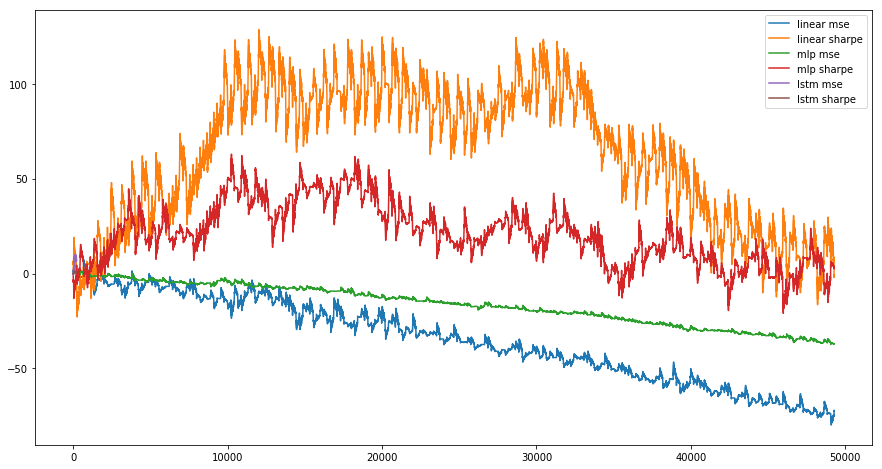

In [82]:
plt.figure(figsize=figsize)
plt.plot(np.cumsum(lin_mse_rets), label='linear mse')
plt.plot(np.cumsum(lin_sharpe_rets), label='linear sharpe')
plt.plot(np.cumsum(mlp_mse_rets), label='mlp mse')
plt.plot(np.cumsum(mlp_sharpe_rets), label='mlp sharpe')
plt.plot(np.cumsum(lstm_mse_rets), label='lstm mse')
plt.plot(np.cumsum(lstm_sharpe_rets), label='lstm sharpe')
plt.legend()

## Your job:



- Improve the performance of the models
- What is our out of sample performance?
- What other metrics can you used to evaluate performance?
  - Maxdraw down?
  - Sharpe?

---

# How do we improve this?

Impactful way to improve performance:
- Use less noisy input features 
  - e.g: n day returns. Rather than just the log ret to the last day, also do the log ret to n days before.
- Use more assets and history
  - Increases the volume of data you train on.
- Hyperparameter search:
  - Determine optimum epoch size, optimum model type, optimum loss function, etc...


Many of these improvements have been implemented and their performance demonstrated in this paper, Lim et al: https://arxiv.org/abs/1904.04912
